In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import cv2
import tqdm as tqdm
import sys
sys.path.append(os.path.abspath(".."))
from src.dataloaders import create_data_loaders
from src.model import CNNmodel



In [3]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/processed/medical_images_resized/" + labels['id'] + ".png"
pd.set_option('display.max_colwidth', None)
labels.head()


,id,label,file_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/processed/medical_images_resized/f38a6374c348f90b587e046aac6079959adf3835.png
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/processed/medical_images_resized/c18f2d887b7ae4f6742ee445113fa1aef383ed77.png
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/processed/medical_images_resized/755db6279dae599ebb4d39a9123cce439965282d.png
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/processed/medical_images_resized/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.png
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/processed/medical_images_resized/068aba587a4950175d04c680d38943fd488d6a9d.png


Checking create_data_loaders works and images are read properly

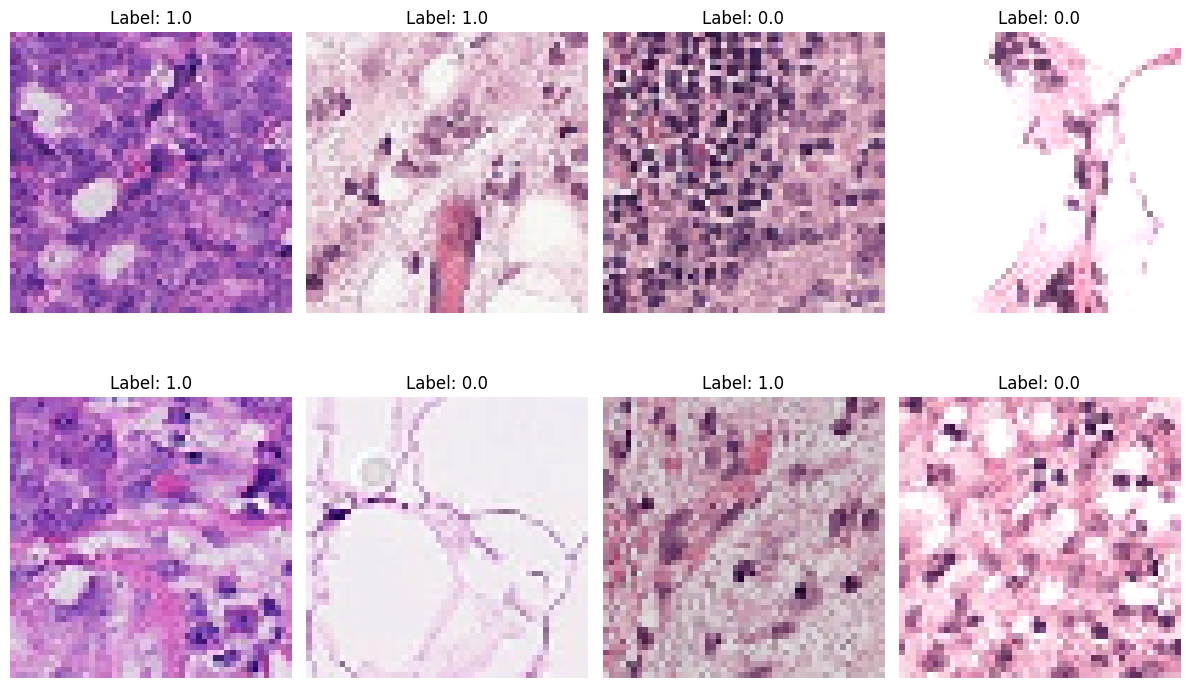

In [4]:
train_loader, val_loader = create_data_loaders(labels, batch_size=16)
imgs, labels = next(iter(train_loader))
imgs = imgs.permute(0, 2, 3, 1).numpy()
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow((imgs[i] * 0.5 + 0.5))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()



Save resized images localy to reduce processing time during training

In [18]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/raw/histopathologic-cancer-detection/train/" + labels['id'] + ".tif"

resized_file_paths = []

for idx, row in tqdm.tqdm(labels.iterrows(), total=len(labels)):
    orig_path = row['file_path']
    img = cv2.imread(orig_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (50,50))

    # Save to preprocessed folder
    new_name = f"{row['id']}.png"
    save_path = os.path.join("E:/Coding_stuffs/Python/notebooks/Medical_image_classification/data/processed/medical_images_resized", new_name)
    cv2.imwrite(save_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    resized_file_paths.append(save_path)

100%|██████████| 220025/220025 [24:35<00:00, 149.12it/s]


In [ ]:
print(torch.cuda.is_available())  # True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs detected
print(torch.cuda.get_device_name(0))  # Name of the first GPU
x = torch.randn(2, 3)
print(x.device)  # Should print 'cpu'

x = x.to('cuda')
print(x.device)  # Should print 'cuda:0'
model = CNNmodel()
print(next(model.parameters()).device)  # Should print 'cpu'

model = model.to('cuda')
print(next(model.parameters()).device)

for path in labels['file_path'][:10]:
    print(path, os.path.exists(path))

adujstable img input testing

In [12]:
import math
x = (50, 50)
x = list(x)
x = [i // 2**3 for i in x]
x = math.prod(x)
print(x)


36
